# Predicting Sale Prices for Ames Iowa Housing Dataset

#### By: Julia Kelman: [GitHub](https://git.generalassemb.ly/julia-kelman/)

## Problem Statement

Creating an app so individuals can estimate the price of their homes before they sell. 

Need to mention how I'm planning to solve this problem (regression model), mention our metric (selected based on RMSE)

## Executive Summary

## Table of Contents 

- [Ames Housing Data Import](#Loading-Data) 
- [Data Cleaning](#Data-Cleaning) 
- [Exploratory Data Analysis](#EDA) 
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)  
    - [Baseline Model](#Baseline-Model)  
    - [Linear Regression](#Linear-Regression)  
    - [Ridge](#Ridge)  
    - [Lasso](#Lasso)  
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)
- [References](#References)
- [Kaggle Submission](#Kaggle-Submission)


## Loading Data

In [1]:
import warnings
warnings.filterwarnings("ignore") # Shhhh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer

%matplotlib inline

In [2]:
# Reading the training dataset: 
df = pd.read_csv('../datasets/train.csv') 

In [3]:
# Reading the Kaggle validation dataset: 
val = pd.read_csv('../datasets/test.csv')  

In [4]:
# Setting display options 
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

In [5]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [6]:
df.shape

(2051, 81)

## Data Cleaning

In [7]:
# Investigating nulls 
df.isnull().sum().sum()

9822

According to information from the original data dictionary, many features' 'NA' are actually a way of encoding valid data. Those features need to be reformated. For other features (where NAs are actual missing values) we need to impute the mean or mode depending on the data type.

During the cleaning process, every feature was investigated and cleaned. The steps taken were compiled into the following function:

In [8]:
def format_data_cleaning(df_train, df_holdout): 
    # Removing NaNs that actually have meaning:
    df_train['Alley'] = df_train['Alley'].map({np.nan: 'No_alley', 'Pave':'Pave', 'Grvl':'Grvl'})
    df_train['Bsmt Qual'] = df_train['Bsmt Qual'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_train['Bsmt Cond'] = df_train['Bsmt Cond'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_train['Bsmt Exposure'] = df_train['Bsmt Exposure'].map({np.nan: 0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
    df_train['BsmtFin Type 1'] = df_train['BsmtFin Type 1'].map({np.nan: 0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    df_train['BsmtFin Type 2'] = df_train['BsmtFin Type 2'].map({np.nan: 0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    df_train['Fireplace Qu'] = df_train['Fireplace Qu'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_train['Garage Type'] = df_train['Garage Type'].map({np.nan: 'No Garage', 'Detchd':'Detchd', 'CarPort':'CarPort', 'BuiltIn':'BuiltIn', 'Basment':'Basment', 'Attchd':'Attchd', '2Types':'2Types'})
    df_train['Garage Finish'] = df_train['Garage Finish'].map({np.nan: 0, 'Unf':1, 'RFn':2, 'Fin':3})    
    df_train['Garage Qual'] = df_train['Garage Qual'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_train['Garage Cond'] = df_train['Garage Cond'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_train['Pool QC'] = df_train['Pool QC'].map({np.nan: 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    df_train['Fence'] = df_train['Fence'].map({np.nan: 'No Fence', 'MnWw':'MnWw', 'GdWo':'GdWo', 'MnPrv':'MnPrv', 'GdPrv':'GdPrv'})
    df_train['Misc Feature'] = df_train['Misc Feature'].map({np.nan: 'None', 'TenC':'TenC', 'Shed':'Shed', 'Othr':'Othr', 'Gar2':'Gar2', 'Elev':'Elev'})
    # Fixing Datatypes: 
    df_train['Id'] = df_train['Id'].astype(str)
    df_train['PID'] = df_train['PID'].astype(str)
    df_train['MS SubClass'] = df_train['MS SubClass'].astype(str)
    # Inputing mean/mode for remaining NaNs: 
    for column in df_train.columns:
        if df_train[column].dtype != 'O':
            df_train[column].fillna(df_train[column].mean(), inplace=True)
        else: 
            df_train[column].fillna(df_train[column].mode(), inplace=True)
    #Dealing with Mas Vnr Type feature: 
    df_train['Mas Vnr Type'].fillna('None', inplace=True)
    
    # Removing NaNs that actually have meaning:
    df_holdout['Alley'] = df_holdout['Alley'].map({np.nan: 'No_alley', 'Pave':'Pave', 'Grvl':'Grvl'})
    df_holdout['Bsmt Qual'] = df_holdout['Bsmt Qual'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_holdout['Bsmt Cond'] = df_holdout['Bsmt Cond'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_holdout['Bsmt Exposure'] = df_holdout['Bsmt Exposure'].map({np.nan: 0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
    df_holdout['BsmtFin Type 1'] = df_holdout['BsmtFin Type 1'].map({np.nan: 0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    df_holdout['BsmtFin Type 2'] = df_holdout['BsmtFin Type 2'].map({np.nan: 0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    df_holdout['Fireplace Qu'] = df_holdout['Fireplace Qu'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_holdout['Garage Type'] = df_holdout['Garage Type'].map({np.nan: 'No Garage', 'Detchd':'Detchd', 'CarPort':'CarPort', 'BuiltIn':'BuiltIn', 'Basment':'Basment', 'Attchd':'Attchd', '2Types':'2Types'})
    df_holdout['Garage Finish'] = df_holdout['Garage Finish'].map({np.nan: 0, 'Unf':1, 'RFn':2, 'Fin':3})    
    df_holdout['Garage Qual'] = df_holdout['Garage Qual'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_holdout['Garage Cond'] = df_holdout['Garage Cond'].map({np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df_holdout['Pool QC'] = df_holdout['Pool QC'].map({np.nan: 0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    df_holdout['Fence'] = df_holdout['Fence'].map({np.nan: 'No Fence', 'MnWw':'MnWw', 'GdWo':'GdWo', 'MnPrv':'MnPrv', 'GdPrv':'GdPrv'})
    df_holdout['Misc Feature'] = df_holdout['Misc Feature'].map({np.nan: 'None', 'TenC':'TenC', 'Shed':'Shed', 'Othr':'Othr', 'Gar2':'Gar2', 'Elev':'Elev'})
    # Fixing Datatypes: 
    df_holdout['Id'] = df_holdout['Id'].astype(str)
    df_holdout['PID'] = df_holdout['PID'].astype(str)
    df_holdout['MS SubClass'] = df_holdout['MS SubClass'].astype(str)
    # Inputing mean for remaining NaNs: 
    for column in df_holdout.columns:
        if df_holdout[column].dtype != 'O':
            df_holdout[column].fillna(df_train[column].mean(), inplace=True)
        else: 
            df_holdout[column].fillna(df_train[column].mode(), inplace=True)
    #Dealing with Mas Vnr Type and Electrical features: 
    df_holdout['Mas Vnr Type'].fillna('None', inplace=True)
    df_holdout['Electrical'].fillna('SBrkr', inplace=True) #'SBrKr' is the mode of the training datatset for this feature

In [9]:
# Cleaning our dataframe:
format_data_cleaning(df, val)

In [10]:
# Confirming there are no more nulls 
df.isnull().sum().sum()

0

There are no more missing values in our dataset.

In [11]:
# A maximum year of 2207 does not make sense. Let's invistigate further to see if this data can be corrected.
df['Garage Yr Blt'].sort_values(ascending=False).head()

1699    2207.0
1241    2010.0
144     2010.0
1732    2009.0
1700    2009.0
Name: Garage Yr Blt, dtype: float64

In [12]:
# Let's take a closer look at the 1699 row 
df.loc[1699, :]
# Considering that the house was built in 2006 and remodeled in 2007. It is a safe assumption to make that 2207 should be 2007.

Id                      2261
PID                916384070
MS SubClass               20
MS Zoning                 RL
Lot Frontage              68
Lot Area                8298
Street                  Pave
Alley               No_alley
Lot Shape                IR1
Land Contour             HLS
Utilities             AllPub
Lot Config            Inside
Land Slope               Gtl
Neighborhood          Timber
Condition 1             Norm
Condition 2             Norm
Bldg Type               1Fam
House Style           1Story
Overall Qual               8
Overall Cond               5
Year Built              2006
Year Remod/Add          2007
Roof Style               Hip
Roof Matl            CompShg
Exterior 1st         VinylSd
Exterior 2nd         VinylSd
Mas Vnr Type            None
Mas Vnr Area         99.6959
Exter Qual                Gd
Exter Cond                TA
Foundation             PConc
Bsmt Qual                  4
Bsmt Cond                  3
Bsmt Exposure              3
BsmtFin Type 1

In [13]:
# Correcting the erroneous Garage year built datapoint 
df.loc[1699, 'Garage Yr Blt'] = 2007

In order to be in an appropriate format to be included in a model, the data needs to be numeric.  
As a result, more features need to be reformated.

In [14]:
# Creating function to reproduce data cleaning and formating: 
def format_model_prep(dataframe): 
    dataframe['Lot Shape'] = dataframe['Lot Shape'].map({'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3':3})
    dataframe['Utilities'] = dataframe['Utilities'].map({'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub':4})
    dataframe['Land Slope'] = dataframe['Land Slope'].map({'Gtl':1, 'Mod':2, 'Sev':3})
    dataframe['Central Air'] = dataframe['Central Air'].map({'Y':1, 'N':0})
    dataframe['Functional'] = dataframe['Functional'].map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8})
    dataframe['Heating QC'] = dataframe['Heating QC'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataframe['Exter Qual'] = dataframe['Exter Qual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataframe['Exter Cond'] = dataframe['Exter Cond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataframe['Kitchen Qual'] = dataframe['Kitchen Qual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataframe['Paved Drive'] = dataframe['Paved Drive'].map({'N':0, 'P':1, 'Y':2})
    dataframe['Age'] = dataframe['Yr Sold'] - df['Year Remod/Add']
    dataframe['True TotRms AbvGrd'] =  dataframe['TotRms AbvGrd'] + df['Full Bath'] + df['Half Bath'] 

In [15]:
# Formating our dataframe:
format_model_prep(df)

In [16]:
# Confirming data types
df.dtypes

Id                     object
PID                    object
MS SubClass            object
MS Zoning              object
Lot Frontage          float64
Lot Area                int64
Street                 object
Alley                  object
Lot Shape               int64
Land Contour           object
Utilities               int64
Lot Config             object
Land Slope              int64
Neighborhood           object
Condition 1            object
Condition 2            object
Bldg Type              object
House Style            object
Overall Qual            int64
Overall Cond            int64
Year Built              int64
Year Remod/Add          int64
Roof Style             object
Roof Matl              object
Exterior 1st           object
Exterior 2nd           object
Mas Vnr Type           object
Mas Vnr Area          float64
Exter Qual              int64
Exter Cond              int64
Foundation             object
Bsmt Qual               int64
Bsmt Cond               int64
Bsmt Expos

The data is now in appropriate type. 

In [17]:
# Confirming the format
df.describe()

,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Misc Val,Mo Sold,Yr Sold,SalePrice,Age,True TotRms AbvGrd
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,69.055200,10065.208191,0.404193,3.998537,1.052657,6.112140,5.562165,1971.708922,1984.190151,99.695909,3.406143,3.085812,3.490005,2.929303,1.628961,3.564603,442.300488,1.274500,47.959024,567.728293,1057.987805,4.158459,0.931253,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,3.517309,6.435885,7.843003,0.590931,1.763530,1978.610282,1.723062,1.776585,473.671707,2.803023,2.810336,1.833740,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,0.010726,51.574354,6.219893,2007.775719,181469.701609,23.585568,8.384203
std,21.306357,6742.488909,0.566514,0.049365,0.244264,1.426271,1.104497,30.177889,21.036250,174.021770,0.587962,0.372792,0.901637,0.572009,1.079440,2.125592,461.091621,0.949571,164.960652,444.846247,449.301078,0.964112,0.253085,396.446923,425.671046,51.068870,500.447829,0.522418,0.251582,0.549279,0.501043,0.826618,0.209790,0.665577,1.560225,0.683409,0.638516,1.807074,24.211852,0.898969,0.764351,215.881887,0.721253,0.716094,0.534792,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,0.173576,573.393985,2.744736,1.312014,79258.659352,21.021078,2.119739
min,21.000000,1300.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,-2.000000,3.000000
25%,60.000000,7500.000000,0.000000,4.000000,1.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,220.000000,793.000000,3.000000,1.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,5.000000,8.000000,0.000000,0.000000,1962.000000,1.000000,1.000000,319.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000,4.000000,7.000000
50%,69.055200,9430.000000,0.000000,4.000000,1.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,3.000000,3.000000,4.000000,3.000000,1.000000,4.000000,368.000000,1.000000,0.000000,475.000000,995.000000,5.000000,1.000000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,3.000000,6.000000,8.000000

In [18]:
df.shape

(2051, 83)

## EDA

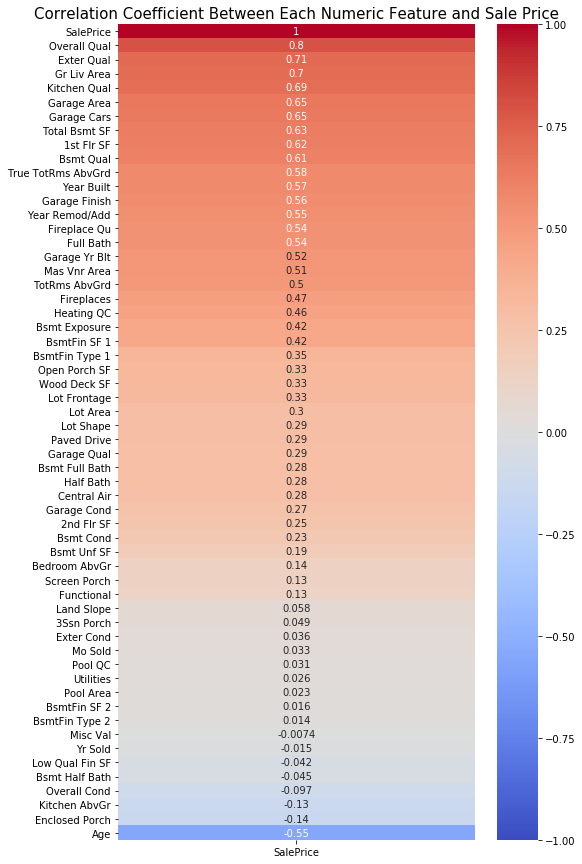

In [19]:
# Correlation heatmap to identify features with strongest correlation to our target 
plt.figure(figsize=(8, 15))
sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False), 
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True);
plt.title('Correlation Coefficient Between Each Numeric Feature and Sale Price', size=15);
# Code for this graph has been adapted from Riley Dallas' code

Interpretation: The 20 numerical features with the highest correlation with Sale Price:  
1. Overall Quality 
1. External Quality
1. Above ground living area (Gr Liv Area)  
1. Kitchen Quality
1. Garage Area  
1. Garage Cars  
1. Total Basement Sq Ft
1. Basement Quality
1. True Total Rooms Above Ground (True TotRms AbvGrd)
1. Year Built 
1. Garage Finish
1. Year Remodeled (Remod/Add)
1. Fireplace Quality 
1. Masonry Veneer Area (Mas Vnr Area)
1. Fireplaces
1. Heating Quality
1. Age 
1. Basement Exposure 
1. Basement Finished Type I
1. Basement Type 1 Finished Sq Ft

Note:  
- 1st Floor Sq Ft not included in this list because already taken into account in the 'Gr Liv Area' feature.  
- Garage year built not included because already taken into account in the year built and/or year remod/add feature. 
- Full Bath not included because already taken into account in the True TotRmd AbvGrd feature. 
- Total Rooms above Grade not included because already taken into account in the True TotRmd AbvGrd feature. 

In [20]:
features_num = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Garage Area', 'Garage Cars', 
                'Total Bsmt SF', 'Bsmt Qual', 'Year Built', 'Garage Finish','True TotRms AbvGrd', 'Year Remod/Add', 'Fireplace Qu', 'Mas Vnr Area', 
                'Fireplaces', 'Heating QC', 'Age', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1']

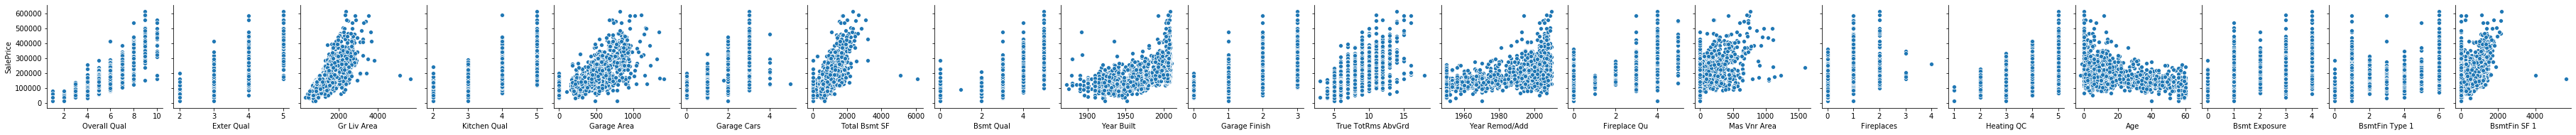

In [21]:
sns.pairplot(df, x_vars = features_num, y_vars=['SalePrice']);

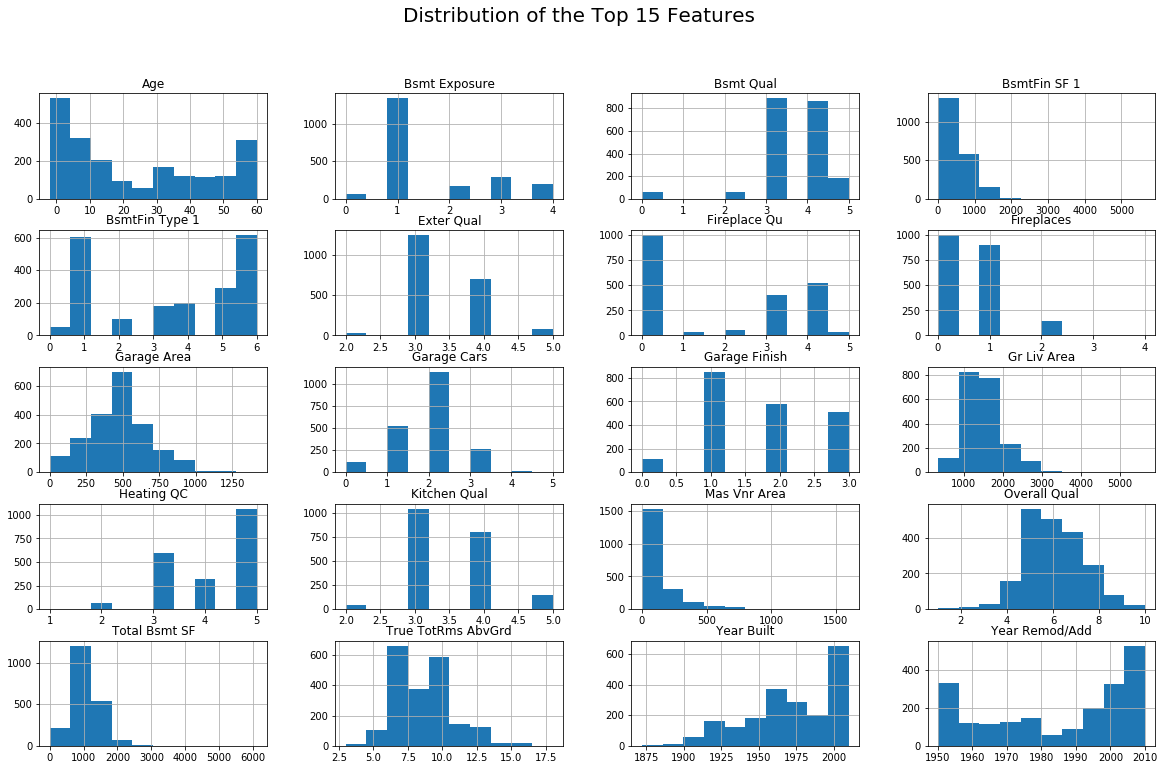

In [22]:
df[features_num].hist(figsize=(20,12));
plt.suptitle('Distribution of the Top 15 Features', size=20);

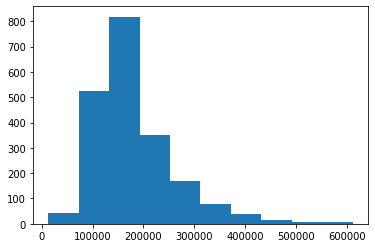

In [23]:
plt.hist(df['SalePrice']);

Interpretation: Right skewed. We're gonna want to take the log of sale price in our model

## Model Preparation

In [24]:
df = pd.get_dummies(df, columns = ['Neighborhood', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 
                                   'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 
                                  'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Electrical', 
                                   'Garage Type', 'Fence', 'Misc Feature', 'Sale Type', 'Mo Sold'])

In [25]:
X = df.drop(columns = ['SalePrice', 'Id', 'PID', 'Yr Sold', 'Year Remod/Add', 'TotRms AbvGrd', 'Full Bath', 'Half Bath'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Modeling

### Baseline Model

In [27]:
from sklearn.dummy import DummyRegressor
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)
dummy_mean.score(X_test, y_test)  
# Code from https://chrisalbon.com/machine_learning/model_evaluation/create_baseline_regression_model/

-0.00043273813883448753

### Linear Regression

In [30]:
lr_all = LinearRegression()

In [31]:
cross_val_score(lr_all, X, y, cv=5).mean()

0.8443794370081126

In [32]:
lr_all.fit(X_train, y_train)

# Training score 
lr_all.score(X_train, y_train)
print(f' Training Score: {lr_all.score(X_train, y_train)}')
      
#Testing score
lr_all.score(X_test, y_test)
print(f' Testing Score: {lr_all.score(X_test, y_test)}')

 Training Score: 0.9346041848134197
 Testing Score: 0.8991826455484687


### Ridge

In [33]:
# Instantiate.
ridge = Ridge(alpha = 10, )

# Fit.
ridge.fit(X_train, y_train)

# Evaluate model using R2.
print(ridge.score(X_train, y_train)) 
print(ridge.score(X_test, y_test))

0.9031230883864607
0.8959346779467351


In [34]:
r_alphas = np.logspace(0, 4, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(
          alphas = r_alphas,
          scoring= 'r2', 
          cv = 5)

# Fit model using best ridge alpha!
ridge_cv.fit(X_train, y_train);

In [35]:
ridge_cv.alpha_

10.235310218990262

In [36]:
print(ridge_cv.score(X_train, y_train)) 
print(ridge_cv.score(X_test, y_test))

0.902924760117756
0.8960311901032544


### Lasso

In [72]:
l_alphas = np.logspace(-1, 2, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV( 
                alphas = l_alphas,
                cv=5)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train, y_train);

In [73]:
lasso_cv.alpha_

53.366992312063125

In [74]:
print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))

0.9248075578618729
0.910828014531655


## Model Selection

In [75]:
cross_val_score(lr_all, X, y, cv=5).mean()

0.8443794370081126

In [76]:
cross_val_score(lasso_cv, X, y, cv=5).mean()

0.8587711543458235

In [77]:
cross_val_score(ridge_cv, X, y, cv=5).mean()

0.8552725148129154

In [43]:
# I want the best predictive power 

## Model Evaluation

In [44]:
def calc_rmse(model, X, y): 
    model_prediction = model.predict(X)
    MSE = metrics.mean_squared_error(y, model_prediction)
    RMSE = np.sqrt(MSE)
    return print(f' The RMSE is {RMSE}')

In [45]:
calc_rmse(lr_all, X_train, y_train)
calc_rmse(lr_all, X_test, y_test)

 The RMSE is 20337.088186164703
 The RMSE is 24880.13363261788


In [46]:
pred_1 = lr_all.predict(X_test)
pred_1[:10]

array([129545.21197427, 220316.89726475, 301219.34022682, 123545.02285671,
       208490.0861919 , 391985.66895898, 160918.17134002, 305365.032294  ,
       156684.24660966, 106386.36130836])

In [80]:
y_test[:10]

1124    132500
188     226000
1727    250000
1658    128000
1424    203160
100     387000
56      149500
1477    319900
1650    167900
1157     98000
Name: SalePrice, dtype: int64

In [79]:
pred_1 = lasso_cv.predict(X_test)
pred_1[:10]

array([129717.42055542, 221994.57233476, 307055.36053852, 113411.94160055,
       209165.24515975, 387887.0747007 , 168629.73102875, 304144.99742888,
       162823.19164026,  75352.23408506])

In [83]:
calc_rmse(lasso_cv, X_train, y_train)
calc_rmse(lasso_cv, X_test, y_test)

 The RMSE is 21807.249280932912
 The RMSE is 23399.106735654765


## Conclusion

## Recommendations

## References

---

# Kaggle Submission

In [50]:
val.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0000,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,2,3,1,1,0,1,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,0,Detchd,1910.0,1,1,440,1,1,Y,0,60,112,0,0,0,0,No Fence,None,0,4,2006,WD
1,2718,905108090,90,RL,69.0552,9662,Pave,No_alley,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,4,3,1,1,0,1,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,0,Attchd,1977.0,3,2,580,3,3,Y,170,0,0,0,0,0,0,No Fence,None,0,8,2006,WD
2,2414,528218130,60,RL,58.0000,17104,Pave,No_alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,4,4,3,6,554,1,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,4,Attchd,2006.0,2,2,426,3,3,Y,100,24,0,0,0,0,0,No Fence,None,0,9,2006,New
3,1989,902207150,30,RM,60.0000,8520,Pave,No_alley,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,3,3,1,1,0,1,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,0,Detchd,1935.0,1,2,480,2,3,N,0,0,184,0,0,0,0,No Fence,None,0,7,2007,WD
4,625,535105100,20,RL,69.0552,9500,Pave,No_alley,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,4,3,1,4,609,1,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,4,Attchd,1963.0,2,2,514,3,3,Y,0,76,0,0,185,0,0,No Fence,None,0,7,2009,WD


In [51]:
val = pd.get_dummies(val, columns = ['Neighborhood', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 
                                   'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 
                                  'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Electrical', 
                                   'Garage Type', 'Fence', 'Misc Feature', 'Sale Type', 'Mo Sold'])

In [52]:
format_model_prep(val)

In [53]:
df.shape

(2051, 255)

In [54]:
val.shape

(878, 242)

In [55]:
missing_cols = set(X_train.columns) - set(val.columns)
missing_cols

{'Condition 2_Artery',
 'Condition 2_PosN',
 'Condition 2_RRAe',
 'Condition 2_RRAn',
 'Condition 2_RRNn',
 'Electrical_Mix',
 'Exterior 1st_CBlock',
 'Exterior 1st_ImStucc',
 'Exterior 1st_Stone',
 'Exterior 2nd_Stone',
 'Heating_OthW',
 'Heating_Wall',
 'MS SubClass_150',
 'MS Zoning_A (agr)',
 'Misc Feature_Elev',
 'Misc Feature_TenC',
 'Neighborhood_GrnHill',
 'Neighborhood_Landmrk',
 'Roof Matl_ClyTile',
 'Roof Matl_Membran'}

In [56]:
for col in missing_cols:
    val[col] = 0 

In [57]:
val.shape

(878, 262)

In [58]:
# Confirming no null values: 
val.isnull().sum().sum()

0

In [59]:
filtered_val = val.drop(columns = ['Id', 'PID', 'Yr Sold', 'Year Remod/Add', 'TotRms AbvGrd', 'Full Bath', 'Half Bath'])

In [60]:
X_train.shape

(1538, 247)

In [61]:
X_test.shape

(513, 247)

In [62]:
filtered_val.shape

(878, 255)

In [63]:
disc_col = set(filtered_val.columns) - set(X_train.columns)
disc_col

{'Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Heating_Floor',
 'Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Sale Type_VWD'}

In [64]:
preds = lr_all.predict(filtered_val)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 247 is different from 255)

In [ ]:
preds[:10]

In [ ]:
preds_reversed = pt_y.inverse_transform(preds.reshape(-1,1))

In [ ]:
preds_reversed[:10]